In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile


zip_path = '/content/drive/MyDrive/DL_Project/archive.zip'
local_extract_path = '/content/DL_Project'


if not os.path.exists(local_extract_path):
    print("Data not found on local SSD. Extracting now...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(local_extract_path)
    print("Extraction complete.")
else:
    print("Data already exists on local SSD. Skipping extraction.")

# 4. Verify the directories
train_dir = os.path.join(local_extract_path, 'seg_train/seg_train')
test_dir = os.path.join(local_extract_path, 'seg_test/seg_test')

print(f"Training path ready: {train_dir}")

Data not found on local SSD. Extracting now...
Extraction complete.
Training path ready: /content/DL_Project/seg_train/seg_train


In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


train_dir = './DL_Project/seg_train/seg_train'
test_dir = './DL_Project/seg_test/seg_test'

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
train_path = './DL_Project/seg_train/seg_train'
test_path = './DL_Project/seg_test/seg_test'

train_data = datasets.ImageFolder(root=train_path, transform=train_transform)
test_data = datasets.ImageFolder(root=test_path, transform=test_transform)

class_names = train_data.classes
print(class_names)
print(len(train_data))
print(len(test_data))

train_loader = DataLoader(train_data, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 32, shuffle = False )


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
14034
3000


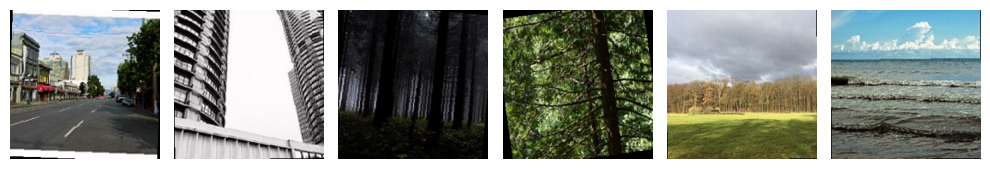

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
# For plotting.
data_iter = iter(train_loader)
# Get an iterator from train loader.
images_batch, labels_batch = next(data_iter)
# One batch of images and labels.
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.229, -0.406/0.229],
    std=[1/0.229, 1/0.224, 1/0.225]
)

fig, axs = plt.subplots(1,6,figsize=(10,4))

for i in range(6):
    ax = axs[i]
    # Determine subplot.
    img = inv_normalize(images_batch[i]).cpu().numpy()
    # Apply inverse normalization.
    img = np.transpose(img, (1,2,0))
    # Rearrange axes to (H,W,C).
    label_idx = labels_batch[i].item()
    # Get label index.
    ax.imshow(img)
    # Show image.

    # Show class name.
    ax.axis('off')
    # Hide axes.
plt.tight_layout()
# Adjust layout.
plt.show()

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 200MB/s]


In [ ]:
for param in model.parameters():
  param.requires_grad = False

num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 6)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr = 0.001)



In [ ]:

train_losses = []
val_accuracies = []

In [ ]:
num_epochs = 2
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0

  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item() * inputs.size(0) # Accumulate loss weighted by batch size

  # Calculate average loss for the epoch
  epoch_loss = running_loss / len(train_data)
  print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")

  # Validation phase
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  val_acc = 100 * correct / total
  val_accuracies.append(val_acc)
  print(f"  Val Acc: {val_acc:.2f}%")

Epoch 1/2, Train Loss: 0.4724
  Val Acc: 88.90%
Epoch 2/2, Train Loss: 0.2869
  Val Acc: 91.00%


In [ ]:
print("--- Starting Phase II: Fine-Tuning ---")

for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

fine_tune_epochs = 2

for epoch in range(fine_tune_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # Fixed indentation

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    # 1. Record Training Loss
    epoch_loss = running_loss / len(train_data)
    train_losses.append(epoch_loss) # <--- Added
    print(f"Fine-Tuning Epoch {epoch+1}/{fine_tune_epochs}, Train Loss: {epoch_loss:.4f}")

    # 2. Record Validation Accuracy (Added Block)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = 100 * correct / total
    val_accuracies.append(val_acc) # <--- Added
    print(f"  Val Acc: {val_acc:.2f}%")

--- Starting Phase II: Fine-Tuning ---
Fine-Tuning Epoch 1/2, Train Loss: 0.2329
  Val Acc: 92.03%
Fine-Tuning Epoch 2/2, Train Loss: 0.1892
  Val Acc: 92.70%


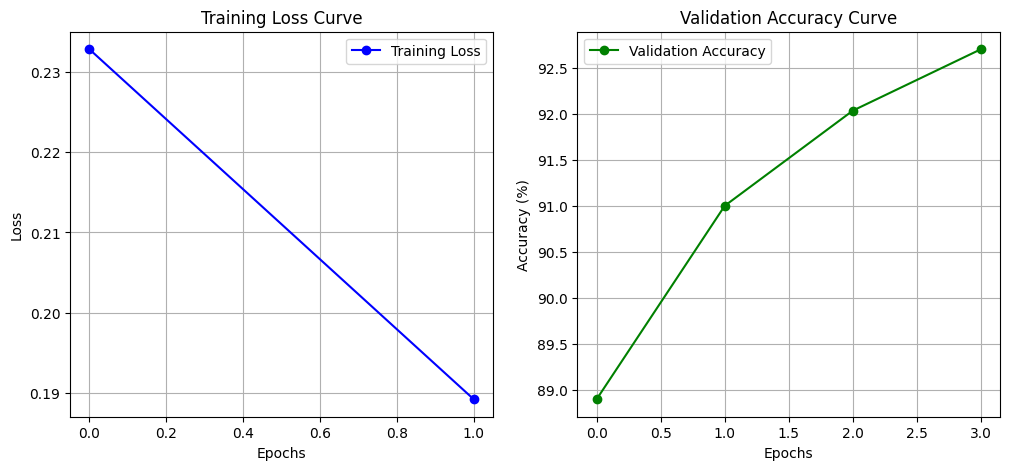

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', marker='o', color='blue')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Plot Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy', marker='o', color='green')
plt.title('Validation Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.grid(True)
plt.legend()

plt.show()

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 89.9 MB/s eta 0:00:00
--- Generating Final Report ---
Running Final Inference...
Final Test Accuracy: 92.70%
Precision: 0.9268
Recall:    0.9270
F1 Score:  0.9265

--- Classification Report ---
              precision    recall  f1-score   support

   buildings       0.91      0.95      0.93       437
      forest       0.99      1.00      0.99       474
     glacier       0.90      0.84      0.87       553
    mountain       0.87      0.87      0.87       525
         sea       0.94      0.98      0.96       510
      street       0.96      0.93      0.95       501

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000



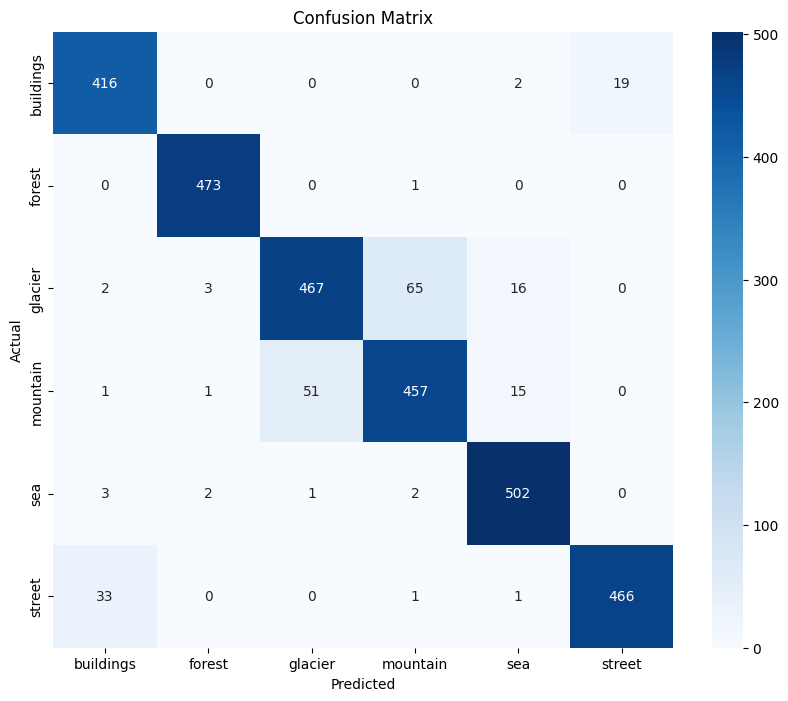

In [ ]:

!pip uninstall scikit-learn -y
!pip install scikit-learn numpy scipy

import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Generating Final Report ---")

# 1. Set Evaluation Mode
model.eval()

all_preds = []
all_labels = []

print("Running Final Inference...")

# 2. Collect Predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 3. Generate Reports
target_names = train_data.classes

# Calculate overall metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f"Final Test Accuracy: {accuracy*100:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# Text Report
print("\n--- Classification Report ---")
print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))

# 4. Visual Confusion Matrix (Bonus for Clarity)
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()